In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#下面三个包是新增的
from sklearn.model_selection import train_test_split
import pandas as pd
import pprint as pp

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [3]:
tr_path = 'covid.train.csv'
tt_path = 'covid.test.csv'
tr_set = pd.read_csv(tr_path)
tt_set = pd.read_csv(tt_path)
print(tr_set.shape)
print(tt_set.shape)
#tr_set.head(5)

(2700, 95)
(893, 94)


In [4]:
tr_set.head(5)#数据量很大，看前5行就行，大致浏览下数据类型

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [5]:
tr_set.columns#查看有多少列特征

Index(['id', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL',
       'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE',
       'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX',
       'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli',
       'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state',
       'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event',
       'public_transit', 'anxious', 'depressed', 'felt_isolated',
       'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1',
       'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1',
       'travel_outside_state.1', 'work_outside_home.1', 'shop.1',
       'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1',
       'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1',
       'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2',
       'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wea

In [6]:
tr_set.drop(['id'], axis = 1, inplace = True)#由于id列用不到，删除id列
tt_set.drop(['id'],axis = 1, inplace = True)

In [7]:
tr_set

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.090116,30.839219,7.849525,1.760094,14.617563,11.163213,18.742673,68.024690,38.920206,13.008853
2696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.779264,30.617100,7.754800,1.780730,14.513419,11.281241,18.539741,67.855755,39.224244,12.725638
2697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.961085,30.595194,7.744075,1.921828,14.160990,11.163526,18.702564,67.731162,38.740651,12.613441
2698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.609582,30.420998,7.687974,1.992580,14.409427,11.330301,19.134697,67.795100,38.595125,12.477227


In [8]:
cols = list(tr_set.columns)#拿到特征列名称

In [9]:
pp.pprint(tr_set.columns)

Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN',
       'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE', 'NV',
       'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'UT',
       'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli',
       'wearing_mask', 'travel_outside_state', 'work_outside_home', 'shop',
       'restaurant', 'spent_time', 'large_event', 'public_transit', 'anxious',
       'depressed', 'felt_isolated', 'worried_become_ill', 'worried_finances',
       'tested_positive', 'cli.1', 'ili.1', 'hh_cmnty_cli.1',
       'nohh_cmnty_cli.1', 'wearing_mask.1', 'travel_outside_state.1',
       'work_outside_home.1', 'shop.1', 'restaurant.1', 'spent_time.1',
       'large_event.1', 'public_transit.1', 'anxious.1', 'depressed.1',
       'felt_isolated.1', 'worried_become_ill.1', 'worried_finances.1',
       'tested_positive.1', 'cli.2', 'ili.2', 'hh_cmnty_cli.2',
       'nohh_cmnty_cli.2', 'wearing_m

In [10]:
pp.pprint(tr_set.info())#看每列数据类型和大小

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 94 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AL                      2700 non-null   float64
 1   AK                      2700 non-null   float64
 2   AZ                      2700 non-null   float64
 3   AR                      2700 non-null   float64
 4   CA                      2700 non-null   float64
 5   CO                      2700 non-null   float64
 6   CT                      2700 non-null   float64
 7   FL                      2700 non-null   float64
 8   GA                      2700 non-null   float64
 9   ID                      2700 non-null   float64
 10  IL                      2700 non-null   float64
 11  IN                      2700 non-null   float64
 12  IA                      2700 non-null   float64
 13  KS                      2700 non-null   float64
 14  KY                      2700 non-null   

In [11]:
WI_index = cols.index('WI') # WI列是states one-hot编码最后一列，取值为0或1，后面特征分析时需要把states特征删掉
WI_index

39

In [12]:
tr_set.iloc[:, 40:].describe() #从上面可以看出wi 列后面是cli, 所以列索引从40开始， 并查看这些数据分布

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,...,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,0.991587,1.016136,29.442496,24.323054,89.682322,8.894498,31.703307,55.277153,16.694342,36.283177,...,16.578290,36.074941,10.257474,2.385735,18.067635,13.058828,19.243283,64.834307,44.568440,16.431280
std,0.420296,0.423629,9.093738,8.446750,5.380027,3.404027,4.928902,4.525917,5.668479,6.675206,...,5.651583,6.655166,4.686263,1.053147,2.250081,1.628589,2.708339,6.220087,5.232030,7.619354
min,0.126321,0.132470,9.961640,6.857181,70.950912,1.252983,18.311941,43.220187,3.637414,21.485815,...,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708
25%,0.673929,0.697515,23.203165,18.539153,86.309537,6.177754,28.247865,51.547206,13.311050,30.740931,...,13.200532,30.606711,6.532543,1.714080,16.420485,11.914167,17.322912,59.782876,40.549987,10.327314
50%,0.912747,0.940295,28.955738,23.819761,90.819435,8.288288,32.143140,55.257262,16.371699,36.267966,...,16.227010,36.041389,9.700368,2.199521,17.684197,12.948749,18.760267,65.932258,43.997637,15.646480
75%,1.266849,1.302040,36.109114,30.238061,93.937119,11.582209,35.387315,58.866130,21.396971,41.659971,...,21.207162,41.508520,13.602566,2.730469,19.503419,14.214320,20.713638,69.719651,48.118283,22.535165
max,2.597732,2.625885,56.832289,51.550450,98.087160,18.552325,42.359074,65.673889,28.488220,50.606465,...,28.488220,50.606465,24.496711,8.162275,28.574091,18.715944,28.366270,77.701014,58.433600,40.959495


In [13]:
tt_set.iloc[:, 40:].describe()#查看测试集数据分布，并和训练集数据分布对比，两者特征之间数据分布差异不是很大

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2
count,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,...,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000
mean,0.972457,0.991809,29.075682,24.018729,89.637506,9.001325,31.620607,55.422982,16.554387,36.371653,...,55.268628,16.444916,36.165898,10.248975,2.369115,17.988147,12.993830,19.238723,64.619920,44.411505
std,0.411997,0.415468,9.596290,8.988245,4.733549,3.655616,4.754570,4.366780,5.688802,6.203232,...,4.350540,5.656828,6.192274,4.498845,1.114366,2.207022,1.713143,2.687435,5.685865,4.605268
min,0.139558,0.159477,9.171315,6.014740,76.895278,2.062500,18.299198,44.062442,3.800684,21.487077,...,44.671891,3.837441,21.338425,2.334654,0.873986,12.696977,8.462444,13.476209,50.212234,35.072577
25%,0.673327,0.689367,21.831730,17.385490,86.587475,7.055039,28.755178,51.726987,13.314242,31.427591,...,51.594301,13.391769,31.330469,6.802860,1.760374,16.406397,11.777101,17.197313,60.358203,40.910546
50%,0.925230,0.936610,28.183014,23.035749,90.123133,8.773243,31.826385,55.750887,17.100556,36.692799,...,55.490325,16.975410,36.213594,9.550393,2.146468,17.719760,12.805424,19.068658,65.148128,44.504010
75%,1.251219,1.267463,36.813772,31.141866,93.387952,10.452262,35.184926,59.185350,20.919961,41.265159,...,59.078475,20.584376,41.071035,13.372731,2.645314,19.423720,14.091551,21.205695,68.994309,47.172065
max,2.488967,2.522263,53.184067,48.142433,97.843221,26.598752,42.887263,63.979007,27.438286,53.513289,...,63.771097,27.362321,52.045373,23.305630,9.118302,27.003564,18.964157,26.007557,76.871053,56.442135


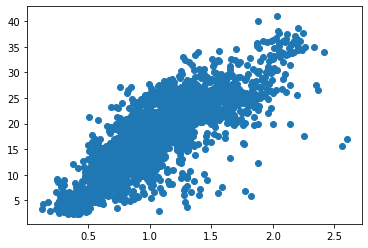

In [14]:
plt.scatter(tr_set.loc[:,'cli'], tr_set.loc[:, 'tested_positive.2'])#画图分析cli特征与目标之间相关性

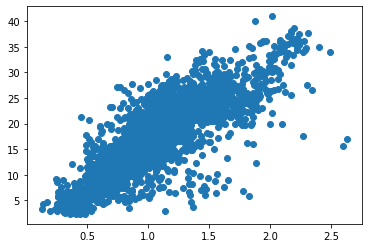

In [15]:
plt.scatter(tr_set.loc[:,'ili'], tr_set.loc[:, 'tested_positive.2'])#画图分析ili特征与目标之间相关性

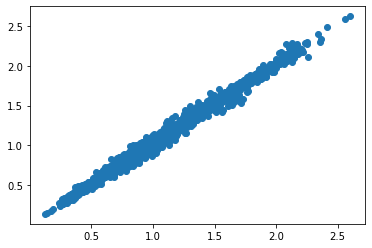

In [16]:
plt.scatter(tr_set.loc[:, 'cli'], tr_set.loc[:, 'ili']) #cli 和ili两者差不多，所以这两个特征用一个就行

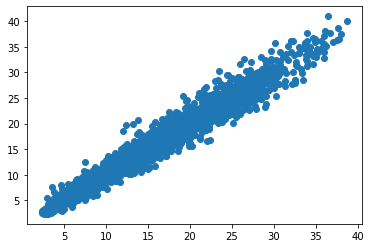

In [17]:
plt.scatter(tr_set.loc[:, 'tested_positive'], tr_set.loc[:, 'tested_positive.2']) #day1 目标值与day3目标值相关性，线性相关的

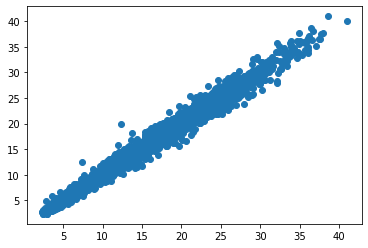

In [18]:
plt.scatter(tr_set.loc[:, 'tested_positive.1'], tr_set.loc[:, 'tested_positive.2'])  #day2 目标值与day3目标值相关性，线性相关的

In [19]:
tr_set.iloc[:, 40:].corr() #上面手动分析太累，还是利用corr方法自动分析,结果就是线性

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
cli,1.000000,0.995735,0.893416,0.882322,-0.107406,-0.095964,0.087305,-0.364165,-0.143318,-0.209020,...,-0.151291,-0.222834,-0.060308,-0.374071,0.237135,0.081456,0.098345,0.228750,0.550564,0.838504
ili,0.995735,1.000000,0.889729,0.878280,-0.109015,-0.106934,0.086355,-0.357443,-0.142082,-0.207210,...,-0.150141,-0.220942,-0.061298,-0.363873,0.245228,0.086229,0.104250,0.222909,0.544776,0.830527
hh_cmnty_cli,0.893416,0.889729,1.000000,0.997225,-0.035441,-0.069595,0.079219,-0.472746,-0.247043,-0.293775,...,-0.253615,-0.300062,-0.136937,-0.433276,0.307581,0.181497,0.203577,0.350255,0.561942,0.879724
nohh_cmnty_cli,0.882322,0.878280,0.997225,1.000000,-0.046063,-0.061914,0.097756,-0.465374,-0.238106,-0.280916,...,-0.245265,-0.287482,-0.129474,-0.424996,0.317836,0.188467,0.203599,0.345448,0.534711,0.869938
wearing_mask,-0.107406,-0.109015,-0.035441,-0.046063,1.000000,-0.220808,-0.735649,-0.691597,-0.788714,-0.807623,...,-0.785281,-0.802659,-0.889021,0.133487,0.204031,-0.067720,0.427533,0.840528,0.340101,-0.069531
travel_outside_state,-0.095964,-0.106934,-0.069595,-0.061914,-0.220808,1.000000,0.264107,0.256911,0.288473,0.349829,...,0.288098,0.336937,0.319736,-0.203611,0.001592,0.064425,-0.370776,-0.131961,-0.093096,-0.097303
work_outside_home,0.087305,0.086355,0.079219,0.097756,-0.735649,0.264107,1.000000,0.631958,0.743673,0.698047,...,0.730349,0.705533,0.758575,-0.110176,0.018259,0.075562,-0.430307,-0.652231,-0.317717,0.034865
shop,-0.364165,-0.357443,-0.472746,-0.465374,-0.691597,0.256911,0.631958,1.000000,0.820916,0.819035,...,0.811055,0.838358,0.787237,0.130046,-0.228007,-0.029168,-0.496368,-0.866789,-0.475304,-0.410430
restaurant,-0.143318,-0.142082,-0.247043,-0.238106,-0.788714,0.288473,0.743673,0.820916,1.000000,0.878576,...,0.993358,0.876107,0.909089,-0.046081,-0.278715,-0.074727,-0.648631,-0.832131,-0.430842,-0.157945
spent_time,-0.209020,-0.207210,-0.293775,-0.280916,-0.807623,0.349829,0.698047,0.819035,0.878576,1.000000,...,0.875365,0.986713,0.912682,-0.040623,-0.169965,0.105281,-0.517139,-0.867460,-0.522985,-0.252125


In [20]:
#锁定上面相关性矩阵最后一列，也就是目标值列，每行是与其相关性大小
data_corr = tr_set.iloc[:, 40:].corr()
target_col = data_corr['tested_positive.2']
target_col

cli                       0.838504
ili                       0.830527
hh_cmnty_cli              0.879724
nohh_cmnty_cli            0.869938
wearing_mask             -0.069531
travel_outside_state     -0.097303
work_outside_home         0.034865
shop                     -0.410430
restaurant               -0.157945
spent_time               -0.252125
large_event              -0.052473
public_transit           -0.448360
anxious                   0.173295
depressed                 0.037689
felt_isolated             0.082182
worried_become_ill        0.262211
worried_finances          0.475462
tested_positive           0.981165
cli.1                     0.838224
ili.1                     0.829200
hh_cmnty_cli.1            0.879438
nohh_cmnty_cli.1          0.869278
wearing_mask.1           -0.065600
travel_outside_state.1   -0.100407
work_outside_home.1       0.037930
shop.1                   -0.412705
restaurant.1             -0.159121
spent_time.1             -0.255714
large_event.1       

In [21]:
feature = target_col[target_col > 0.8] #在最后一列相关性数据中选择大于0.8的行，这个0.8是自己设的超参，大家可以根据实际情况调节
feature

cli                  0.838504
ili                  0.830527
hh_cmnty_cli         0.879724
nohh_cmnty_cli       0.869938
tested_positive      0.981165
cli.1                0.838224
ili.1                0.829200
hh_cmnty_cli.1       0.879438
nohh_cmnty_cli.1     0.869278
tested_positive.1    0.991012
cli.2                0.835751
ili.2                0.826075
hh_cmnty_cli.2       0.878218
nohh_cmnty_cli.2     0.867535
tested_positive.2    1.000000
Name: tested_positive.2, dtype: float64

In [22]:
feature_cols = feature.index.tolist()  #将选择特征名称拿出来
feature_cols.pop() #去掉test_positive标签
pp.pprint(feature_cols) #得到每个需要特征名称列表

['cli',
 'ili',
 'hh_cmnty_cli',
 'nohh_cmnty_cli',
 'tested_positive',
 'cli.1',
 'ili.1',
 'hh_cmnty_cli.1',
 'nohh_cmnty_cli.1',
 'tested_positive.1',
 'cli.2',
 'ili.2',
 'hh_cmnty_cli.2',
 'nohh_cmnty_cli.2']


In [23]:
feats_selected = [cols.index(col) for col in feature_cols]  #获取该特征对应列索引编号，后续就可以用feats + feats_selected作为特征值
feats_selected

[40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]

In [24]:
feats = list(range(40))+feats_selected 
feats

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 57,
 58,
 59,
 60,
 61,
 75,
 76,
 77,
 78,
 79]

In [46]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    '''获取设备(如果GPU可用，使用GPU)'''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    '''绘制DNN (train & dev loss)学习曲线'''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    '''预测你的DNN'''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

train dataset/val dataset/test dataset

1.读取.csv文件 2.提取特征 3.将covid.train.csv分割为train/validation dataset 4.标准化特征

In [26]:
class COVID19Dataset(Dataset):
    '''用于加载和预处理COVID19数据集的数据集'''
    def __init__(self,path,mu,std,mode = 'train',target_only = False):#读取数据和预处理,重写归一化函数
        self.mode = mode 
        
        # Read data into numpy arrays
        with open(path,'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:,1:].astype(float)
            
        if not target_only:#target_only 默认是false, 所以用的是全量特征，如果要用自己选择特征，则实例化这个类的时候，设置成True
            feats = list(range(93))
        else:
            feats = list(range(40))+feats_selected   # feats_selected是我们选择特征, 40代表是states特征
            
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
      
            #如果用只用两个特征，可以忽略前面数据分析过程,直接这样写
            #feats = list(range(40)) + [57, 75]
           
        if self.mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
#             # 划分训练集和验证集,baseline
#             if mode == 'train':
#                 indices = [i for i in range(len(data)) if i % 10 != 0]
#             elif mode == 'dev':
#                 indices = [i for i in range(len(data)) if i % 10 == 0]
                
           #baseline上面这段代码划分训练集和测试集按照顺序选择数据，可能造成数据分布问题，我改成随机选择
            indices_tr, indices_dev = train_test_split([i for i in range(data.shape[0])], test_size = 0.3, 
                                                       random_state = 0)
            #,stratify=indices_dev
            if self.mode == 'train':
                indices = indices_tr
            elif self.mode == 'dev':
                indices = indices_dev
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
#         self.data[:, 40:] = \
#             (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
#             / self.data[:, 40:].std(dim=0, keepdim=True)

#         self.dim = self.data.shape[1]
    #baseline这段代码数据归一化用的是当前数据归一化，事实上验证集上和测试集上归一化一般只能用过去数据即训练集上均值和方差进行归一化
    
        if self.mode == "train":#如果是训练集，均值和方差用自己数据
            self.mu = self.data[:,40:].mean(dim=0,keepdim=True)
            self.std = self.data[:,40:].std(dim=0,keepdim=True)
        else:#测试集和验证集，传进来的均值和方差是来自训练集保存，如何保存均值和方差，看数据dataload部分
            self.mu = mu
            self.std = std
            
        #归一化  又叫分布标准化
        self.data[:,40:] = (self.data[:, 40:] - self.mu) / self.std  #归一化
        self.dim = self.data.shape[1]
        
        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self,index):#索引的时候，读取个数据
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]
    def __len__(self):#返回数据集的size
        return len(self.data)

A DataLoader loads data from a given Dataset into batches.

In [27]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False,mu=None, std=None):
    '''生成数据集，然后放入数据加载器。'''
    dataset = COVID19Dataset(path,mu,std,mode=mode,target_only=target_only)#构建数据集
    if mode == 'train':#如果是训练集，把训练集上均值和方差保存下来
        mu = dataset.mu
        std =dataset.std
    dataloader = DataLoader(dataset,batch_size,shuffle=(mode=='train'),
            drop_last=False,num_workers=n_jobs,pin_memory=True)#构建dataloader
    return dataloader,mu,std

Deep Neural Network

NeuralNet是一个nn.Module。为回归设计的模块。DNN由2个ReLU激活的完全连接层组成。该模块还包含了一个计算损耗的函数cal_loss。

In [275]:
class NeuralNet(nn.Module):
    '''一个简单的完全连接的深层神经网络'''
    def __init__(self,input_dim):
        super().__init__()
        
        # Define your neural network here
        # TODO: 如何修改这个模型以达到更好的性能?
        self.net = nn.Sequential(
            
            nn.Linear(input_dim,68),
            #nn.BatchNorm1d(70),
            nn.ReLU(),
            nn.Linear(68,34),
            nn.ReLU(),
            nn.Linear(34,1)
        )
        #Mean squared error loss (MSE-Loss)均方误差损失
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self,x):
        #''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        
        return self.net(x).squeeze(1)
    
    #compute loss
    def cal_loss(self,pred,target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        eps = 1e-6
        l2_reg = 0
        alpha = 0.0001
        #这段代码是l2正则，但是实际操作l2正则效果不好，大家也也可以调，把下面这段代码取消注释就行
#         for name, w in self.net.named_parameters():
#             if 'weight'  in name:
#                 l2_reg += alpha * torch.norm(w, p = 2).to(device)
        return torch.sqrt(self.criterion(pred, target) + eps) + l2_reg   
        #lr_reg=0, 后面那段代码用的是均方根误差，均方根误差和kaggle评测指标一致，而且训练模型也更平稳

# **Train/Dev/Test**

In [276]:
def train(tr_set,dv_set,model,config,device):
    '''DNN Training'''
    n_epochs = config['n_epochs']  # Maximum number of epochs
    
    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])
    
    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # 记录训练损失的字典，也可以使用两个列表
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # model进入训练模式
        for x, y in tr_set:                     # 遍历数据加载器
            optimizer.zero_grad()               # 梯度清零
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # 在每个阶段之后，在验证集上测试您的模型。
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # 如果您的模型改进了，请保存模型
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # 将模型保存到指定路径
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # 如果您的模型在“config['early_stop']”时停止改进，则停止训练。
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record,dev_mse

##**Validation**

In [277]:
def dev(dv_set, model, device):
    model.eval()                                # 将模型设置为评估模式
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # 积累loss
    total_loss = total_loss / len(dv_set.dataset)              # 计算平均loss

    return total_loss

##**Testing**

In [278]:
def test(tt_set,model,device):
    model.eval()
    preds = []
    for x in tt_set:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds,dim=0).numpy()
    return preds

Config包含用于训练的超参数和保存模型的路径。

In [303]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                    # 使用自己的特征，如果设置成False，用的是全量特征

# 这里超参数没怎么调，已经最优的了
# config = {
#     'n_epochs': 2000,                # maximum number of epochs
#     'batch_size': 200,               # mini-batch size for dataloader
#     'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
#     'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
#         'lr':1e-3,                 # learning rate of SGD
#    # 'momentum': 0.9             # momentum for SGD
#     },
#     'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
#     'save_path': 'models/model.pth'  # your model will be saved here
# }
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 5e-3,                 # learning rate of SGD
        'momentum': 0.1              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [304]:
tr_set, tr_mu ,tr_std = prep_dataloader(tr_path,'train',config['batch_size'],target_only=target_only)
dv_set, dv_mu ,dv_std  = prep_dataloader(tr_path,'dev',config['batch_size'],target_only=target_only,mu=tr_mu, std=tr_std)
tt_set ,tt_mu ,tt_std  = prep_dataloader(tt_path,'test',config['batch_size'],target_only=target_only,mu=tr_mu, std=tr_std)

Finished reading the train set of COVID19 Dataset (1890 samples found, each dim = 54)
Finished reading the dev set of COVID19 Dataset (810 samples found, each dim = 54)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 54)


In [305]:
model = NeuralNet(tr_set.dataset.dim).to(device)

In [306]:
model_loss, model_loss_record,dev_mse = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 17.9978)
Saving model (epoch =    2, loss = 17.9510)
Saving model (epoch =    3, loss = 17.9046)
Saving model (epoch =    4, loss = 17.8581)
Saving model (epoch =    5, loss = 17.8112)
Saving model (epoch =    6, loss = 17.7636)
Saving model (epoch =    7, loss = 17.7149)
Saving model (epoch =    8, loss = 17.6648)
Saving model (epoch =    9, loss = 17.6129)
Saving model (epoch =   10, loss = 17.5585)
Saving model (epoch =   11, loss = 17.5012)
Saving model (epoch =   12, loss = 17.4402)
Saving model (epoch =   13, loss = 17.3747)
Saving model (epoch =   14, loss = 17.3036)
Saving model (epoch =   15, loss = 17.2251)
Saving model (epoch =   16, loss = 17.1378)
Saving model (epoch =   17, loss = 17.0403)
Saving model (epoch =   18, loss = 16.9300)
Saving model (epoch =   19, loss = 16.8041)
Saving model (epoch =   20, loss = 16.6578)
Saving model (epoch =   21, loss = 16.4851)
Saving model (epoch =   22, loss = 16.2783)
Saving model (epoch =   23, loss

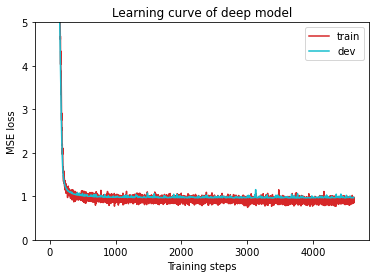

In [299]:
plot_learning_curve(model_loss_record, title='deep model')

In [300]:
print(dev_mse)

0.9688143531481425


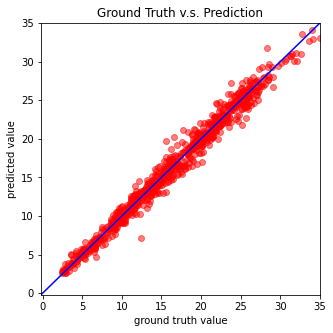

In [301]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [302]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'submit.csv')         # save prediction file to pred.csv

Saving results to submit.csv
